Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')
from google.colab import drive
drive.mount('/content/gdrive')
#root_path = 'gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/' https://drive.google.com/drive/folders/1xekqvECa1jVB5yoovqziTbZcL_WvOeqM?usp=share_link
##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               seed = 123, 
                                                               validation_split = 0.2, 
                                                               subset = 'training', 
                                                               image_size = (img_height, img_width), 
                                                               batch_size = batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               seed = 123, 
                                                               validation_split = 0.2, 
                                                               subset = 'validation', 
                                                               image_size = (img_height, img_width), 
                                                               batch_size = batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

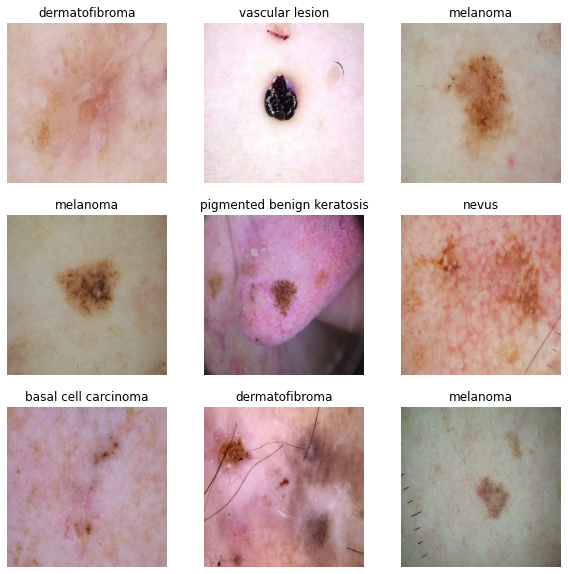

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

### your code goes here, you can use training or validation data to visualize

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
### Your code goes here
num_classes = 9

model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape = (img_height, img_width, 3)),
    layers.Conv2D(16,3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(num_classes)
])


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [12]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 43s 59ms/step - loss: 1.9669 - accuracy: 0.2580 - val_loss: 1.5668 - val_accuracy: 0.4120
Epoch 2/20
169/169 [==============================] - 4s 24ms/step - loss: 1.5072 - accuracy: 0.4186 - val_loss: 1.3756 - val_accuracy: 0.4855
Epoch 3/20
169/169 [==============================] - 4s 23ms/step - loss: 1.2955 - accuracy: 0.5026 - val_loss: 1.2393 - val_accuracy: 0.5627
Epoch 4/20
169/169 [==============================] - 4s 23ms/step - loss: 1.1109 - accuracy: 0.5918 - val_loss: 1.1505 - val_accuracy: 0.5724
Epoch 5/20
169/169 [==============================] - 4s 24ms/step - loss: 0.9469 - accuracy: 0.6565 - val_loss: 0.9526 - val_accuracy: 0.6526
Epoch 6/20
169/169 [==============================] - 4s 23ms/step - loss: 0.7931 - accuracy: 0.7175 - val_loss: 0.9956 - val_accuracy: 0.6689
Epoch 7/20
169/169 [==============================] - 4s 24ms/step - loss: 0.6400 - accuracy: 0.7724 - val_loss: 0.8043 - val_accuracy: 0.708

### Visualizing training results

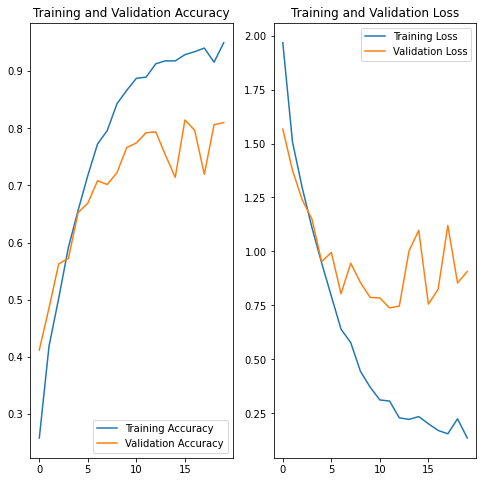

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The Accuracy of the model on Train Data is 91.85% and accuracy of the model on Test Data is 51.8%. This is a clear indication of Overfitting.

Here we are using Augumentation Strategy by rotating and Zooming the image to understand the images of similar class better.

In [17]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip('horizontal',
                                                     input_shape = (img_height,
                                                                    img_width,
                                                                    3)),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.1)
    ]
)

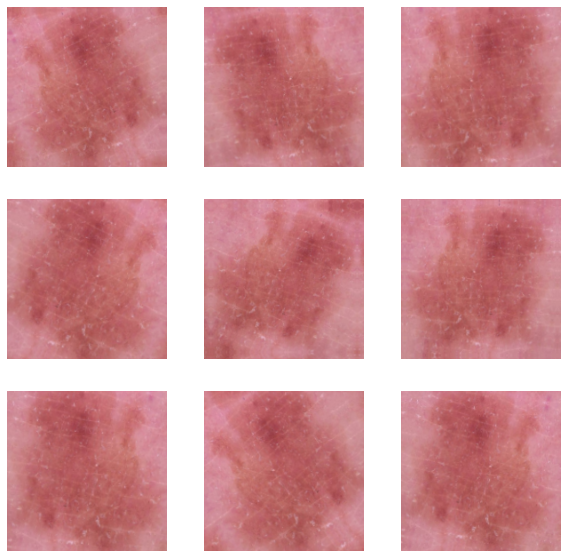

In [18]:
plt.figure(figsize = (10,10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3,3,i+1)
    plt.imshow(augmented_images[0].numpy().astype('uint8'))
    plt.axis('off')

### Todo:
### Create the model, compile and train the model


In [19]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
model = Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(16,3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(num_classes)
])



### Compiling the model

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

### Training the model

In [21]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/20
169/169 [==============================] - 8s 40ms/step - loss: 1.9085 - accuracy: 0.2815 - val_loss: 1.6316 - val_accuracy: 0.3682
Epoch 2/20
169/169 [==============================] - 7s 39ms/step - loss: 1.4943 - accuracy: 0.4305 - val_loss: 1.3852 - val_accuracy: 0.4892
Epoch 3/20
169/169 [==============================] - 7s 41ms/step - loss: 1.3639 - accuracy: 0.4683 - val_loss: 1.4415 - val_accuracy: 0.4410
Epoch 4/20
169/169 [==============================] - 7s 41ms/step - loss: 1.3215 - accuracy: 0.4930 - val_loss: 1.2229 - val_accuracy: 0.5442
Epoch 5/20
169/169 [==============================] - 7s 40ms/step - loss: 1.2413 - accuracy: 0.5250 - val_loss: 1.1889 - val_accuracy: 0.5642
Epoch 6/20
169/169 [==============================] - 7s 40ms/step - loss: 1.1894 - accuracy: 0.5406 - val_loss: 1.1854 - val_accuracy: 0.5561
Epoch 7/20
169/169 [==============================] - 7s 40ms/step - loss: 1.1187 - accuracy: 0.5779 - val_loss: 1.0163 - val_accuracy: 0.6043

### Visualizing the results

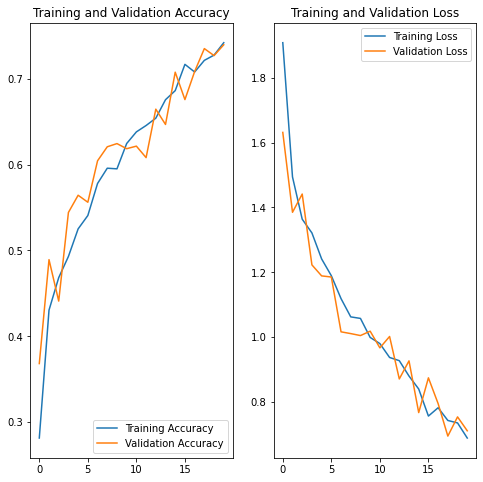

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Here te training accuracy is 74% and validation Accuracy is 71%,which means the model is underfitting. This could mainly be because of Class Imbalance. So lets see the number of images in each class

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [23]:
## Your code goes here.
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train,'*','*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train,'*','*.jpg'))]
len(path_list)

2239

In [24]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,gdrive/My Drive/Skin cancer ISIC The Internati...,actinic keratosis
1,gdrive/My Drive/Skin cancer ISIC The Internati...,actinic keratosis
2,gdrive/My Drive/Skin cancer ISIC The Internati...,actinic keratosis
3,gdrive/My Drive/Skin cancer ISIC The Internati...,actinic keratosis
4,gdrive/My Drive/Skin cancer ISIC The Internati...,actinic keratosis
...,...,...
2234,gdrive/My Drive/Skin cancer ISIC The Internati...,vascular lesion
2235,gdrive/My Drive/Skin cancer ISIC The Internati...,vascular lesion
2236,gdrive/My Drive/Skin cancer ISIC The Internati...,vascular lesion
2237,gdrive/My Drive/Skin cancer ISIC The Internati...,vascular lesion


Class = 0, n = 114 (5.092%)
Class = 1, n = 376 (16.793%)
Class = 2, n = 95 (4.243%)
Class = 3, n = 438 (19.562%)
Class = 4, n = 357 (15.945%)
Class = 5, n = 462 (20.634%)
Class = 6, n = 77 (3.439%)
Class = 7, n = 181 (8.084%)
Class = 8, n = 139 (6.208%)


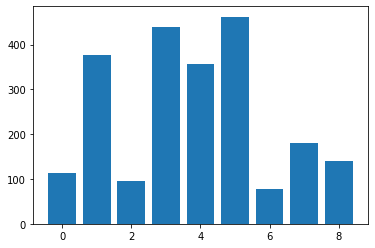

In [25]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
X,y = original_df['Path'],original_df['Label']
y  = LabelEncoder().fit_transform(y)
counter = Counter(y)
for k,v in counter.items():
  per = v/len(y) *100
  print('Class = %d, n = %d (%.3f%%)' % (k,v,per))
plt.bar(counter.keys(), counter.values())
plt.show()

#### - Which class has the least number of samples?
#### - Class 6
#### - Which classes dominate the data in terms proportionate number of samples?
#### - Class 3 and Class 5

Clearly the model is dominated by the images of class 3,4,5 and Class 0,2, 6 have many less samples
To work on this Class Imbalance we  are using Augmentor.We will be adding 500 samples for each class 


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [26]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [27]:
path_to_training_dataset="gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBF77D682E0>: 100%|██████████| 500/500 [00:17<00:00, 28.15 Samples/s]


Initialised with 376 image(s) found.
Output directory set to gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBFF1DC5A90>: 100%|██████████| 500/500 [00:17<00:00, 28.03 Samples/s]


Initialised with 95 image(s) found.
Output directory set to gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBF6C633550>: 100%|██████████| 500/500 [00:18<00:00, 27.75 Samples/s]


Initialised with 438 image(s) found.
Output directory set to gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FBF8C2D4460>: 100%|██████████| 500/500 [01:18<00:00,  6.36 Samples/s]


Initialised with 357 image(s) found.
Output directory set to gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=962x676 at 0x7FBFE03DA9A0>: 100%|██████████| 500/500 [01:21<00:00,  6.15 Samples/s]


Initialised with 462 image(s) found.
Output directory set to gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBF8C306460>: 100%|██████████| 500/500 [00:18<00:00, 27.76 Samples/s]


Initialised with 77 image(s) found.
Output directory set to gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FBF6C6750D0>: 100%|██████████| 500/500 [00:42<00:00, 11.89 Samples/s]


Initialised with 181 image(s) found.
Output directory set to gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBF74F66F40>: 100%|██████████| 500/500 [00:17<00:00, 27.92 Samples/s]


Initialised with 139 image(s) found.
Output directory set to gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBF6C6F5DC0>: 100%|██████████| 500/500 [00:17<00:00, 28.36 Samples/s]


In [28]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [29]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [30]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026212.jpg_b14a57cb-5bc4-45e6-a808-0c34ca970566.jpg',
 'gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025803.jpg_b8f76a05-e54b-43ce-aaf5-249a9548eda1.jpg',
 'gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027580.jpg_9dea8698-9cca-40ae-8d91-57c08567e896.jpg',
 'gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027447.jpg_6ab1d93e-4af1-4754-9ce8-6fedb7421ee5.jpg',
 'gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033358.jpg_9a304e70-2d7c-4eb9-b71a-271bcd57daaf.jpg',
 'gdrive/M

In [31]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [32]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [33]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [34]:
new_df['Label'].value_counts()

pigmented benign keratosis    1462
melanoma                      1438
basal cell carcinoma          1376
nevus                         1357
squamous cell carcinoma       1181
vascular lesion               1139
actinic keratosis             1114
dermatofibroma                1095
seborrheic keratosis          1077
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [35]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [40]:
data_dir_train= pathlib.Path("gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


#### **Todo:** Create a validation dataset

In [42]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [43]:
## your code goes here
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [44]:
model = Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(16,3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [45]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [46]:
epochs = 30
## Your code goes here, use 50 epochs.

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
281/281 [==============================] - 61s 72ms/step - loss: 1.7521 - accuracy: 0.3265 - val_loss: 1.4423 - val_accuracy: 0.4419
Epoch 2/30
281/281 [==============================] - 11s 41ms/step - loss: 1.4040 - accuracy: 0.4586 - val_loss: 1.2913 - val_accuracy: 0.5029
Epoch 3/30
281/281 [==============================] - 12s 43ms/step - loss: 1.2691 - accuracy: 0.5089 - val_loss: 1.3312 - val_accuracy: 0.5091
Epoch 4/30
281/281 [==============================] - 11s 40ms/step - loss: 1.1856 - accuracy: 0.5420 - val_loss: 1.2035 - val_accuracy: 0.5447
Epoch 5/30
281/281 [==============================] - 11s 40ms/step - loss: 1.1247 - accuracy: 0.5743 - val_loss: 1.2160 - val_accuracy: 0.5389
Epoch 6/30
281/281 [==============================] - 11s 41ms/step - loss: 1.0325 - accuracy: 0.6145 - val_loss: 1.0520 - val_accuracy: 0.6182
Epoch 7/30
281/281 [==============================] - 11s 41ms/step - loss: 0.9653 - accuracy: 0.6415 - val_loss: 0.9373 - val_accuracy:

#### **Todo:**  Visualize the model results

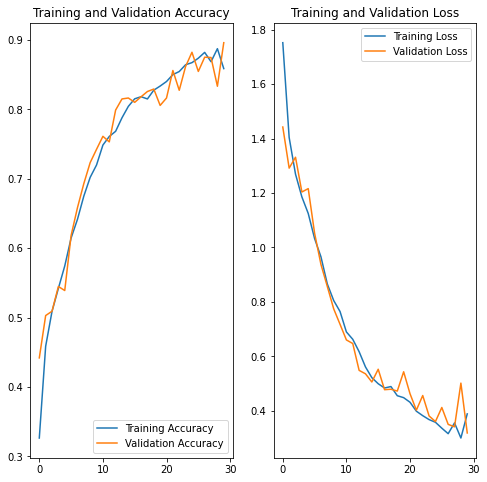

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



Summary:

Initially where the model was overfitting, we have augmented the data rotation and zoom of data to classify the images of similar Class together.

That has eliminated the overfitting but both the train and test accuracies were still low, leading the model to underfit.

We have then checked the number of images under each classes and found that few classes have very less sample images, which created a class imbalance in the model.

We have then used Augumentor and have added 500 samples to each class and trained the model again.

Now, We have a training accuracy of 85.85% and Validation accuracy of 89%. 
So the model has a good accuracy and there is very less difference between train and test accuracies. So, the model looks legit and can be used.
